author: G.Seijo (giovanni.seijo@colorado.edu)

Code to calculate area weigthted time series of mom6 output and other products for comparissons

In [2]:
import requests, xarray, pandas, math, datetime
import numpy as np
from datetime import datetime, timedelta
import xarray as xr
from glob import glob
import os
import matplotlib.pyplot as plt


In [21]:
argo_in = '/glade/work/gseijo/RG_ArgoClim_33pfit_2019_mean.nc'
glorys_in = '/glade/scratch/gseijo/glorys/' #set to directory as we need to concat the daily files (see: load Glorys data section)
mom_in = '/glade/scratch/gseijo/CARIB_025.007.glofas_proc/'
aviso_in = ''
png_out = '/glade/work/gseijo/CARIB_025.007.glofas_proc/'

## load MOM data

In [4]:
ds_mom = xr.open_dataset('/glade/work/gseijo/CARIB_025.007.glofas_proc/CARIB_025.007.glofas_sfc.nc')
#ds_mom_old = xr.open_dataset('/glade/work/gseijo/out_proc_Carib025.002/mom6_carib002_sfc_2004_2014.nc')
ds_mom

<xarray.Dataset>
Dimensions:       (nv: 2, time: 1796, xh: 252, xq: 253, yh: 152, yq: 153)
Coordinates:
  * xh            (xh) float64 -98.38 -98.12 -97.88 ... -36.12 -35.88 -35.62
  * yh            (yh) float64 -5.875 -5.625 -5.375 -5.125 ... 31.38 31.62 31.88
  * time          (time) datetime64[ns] 1999-12-30T12:00:00 ... 2004-11-28T12...
  * nv            (nv) float64 1.0 2.0
  * xq            (xq) float64 -98.5 -98.25 -98.0 -97.75 ... -36.0 -35.75 -35.5
  * yq            (yq) float64 -6.0 -5.75 -5.5 -5.25 ... 31.25 31.5 31.75 32.0
Data variables: (12/17)
    lrunoff       (time, yh, xh) float32 ...
    SSH           (time, yh, xh) float32 ...
    tos           (time, yh, xh) float32 ...
    sos           (time, yh, xh) float32 ...
    SSU           (time, yh, xq) float32 ...
    SSV           (time, yq, xh) float32 ...
    ...            ...
    mlotst        (time, yh, xh) float32 ...
    oml           (time, yh, xh) float32 ...
    average_T1    (time) datetime64[ns] ...
    average_T2    (time) datetime64[ns] ...
    average_DT    (time) timedelta64[ns] ...
    time_bnds     (time, nv) timedelta64[ns] ...
Attributes:
    filename:          CARIB_025.007.mom6.sfc_2000_01.nc
    title:             MOM6 diagnostic fields table for CESM case: CARIB_025.007
    associated_files:  area_t: CARIB_025.007.mom6.static.nc
    grid_type:         regular
    grid_tile:         N/A

In [24]:
means=np.zeros(1796)
for i in range(1796):
    means[i] = ds_mom['tos'][i,:,:].mean()

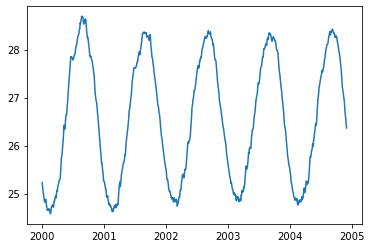

In [25]:
plt.plot(ds_mom.time.values,means)

## load RGargo data

In [10]:
argo_t = xr.open_dataset('/glade/work/gseijo/argo_rgTempTotal_centralcarib_2004_2014.nc')
argo_s = xr.open_dataset('/glade/work/gseijo/argo_rgPsalTotal_centralcarib_2004_2014.nc')


In [11]:
argo_s

<xarray.Dataset>
Dimensions:      (latitude: 3, longitude: 7, pressure: 1, time: 132)
Coordinates:
  * latitude     (latitude) float64 13.5 14.5 15.5
  * longitude    (longitude) float64 -69.5 -68.5 -67.5 -66.5 -65.5 -64.5 -63.5
  * time         (time) datetime64[ns] 2004-01-15 2004-02-15 ... 2014-12-15
  * pressure     (pressure) float64 2.5
Data variables:
    measurement  (latitude, longitude, time, pressure) float64 ...

## areweighted region mean function

In [12]:
#function to calculated an area weighted time series of gridded data.
#Note: function works for RGargo data (need to create something similar for other products)
def areaweighted_region_mean(dxr,latstr,lonstr):
    # given an xarray dataset <grid> for a given depth and time,
    # calculate the mean of the gridded data variable, weighted by grid cell area
    if latstr == 'latitude':
        bfr = dxr.latitude
    elif latstr == 'yh':
        bfr = dxr.yh
    weights = np.cos(np.deg2rad(bfr))
    weights.name = "weights"
    dxr_weighted = dxr.weighted(weights)
    
    return dxr_weighted.mean((lonstr, latstr))

In [13]:
argoT_aw = areaweighted_region_mean(dxr=argo_t,latstr="latitude",lonstr="longitude")
argoS_aw = areaweighted_region_mean(dxr=argo_s,latstr="latitude",lonstr="longitude")

In [14]:
#subset mom to roughly same area as argo data

minlat = np.min(argo_t.latitude)
maxlat = np.max(argo_t.latitude)
minlon = np.min(argo_t.longitude)
maxlon = np.max(argo_t.longitude)
ds_mom_subset = ds_mom.sel(yh=slice(minlat-0.5,maxlat+0.5), xh=slice(minlon-0.5,maxlon+0.5))
#ds_mom_old_subset = ds_mom_old.sel(yh=slice(minlat-0.5,maxlat+0.5), xh=slice(minlon-0.5,maxlon+0.5))

In [15]:
minlon



<xarray.DataArray 'longitude' ()>
array(-69.5)

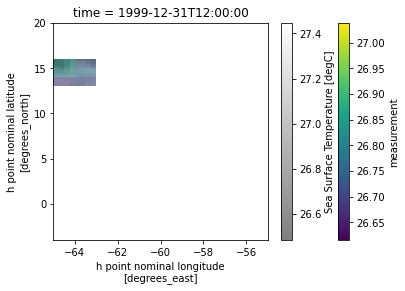

In [16]:
# make plots to confirm regions are similar:
argo_t['measurement'].isel(time=1).plot(xlim=(-65,-55),ylim=(-4,20))
ds_mom_subset['tos'].isel(time=1).plot(xlim=(-65,-55),ylim=(-4,20),cmap='gray',alpha=0.5)

## salinity plots

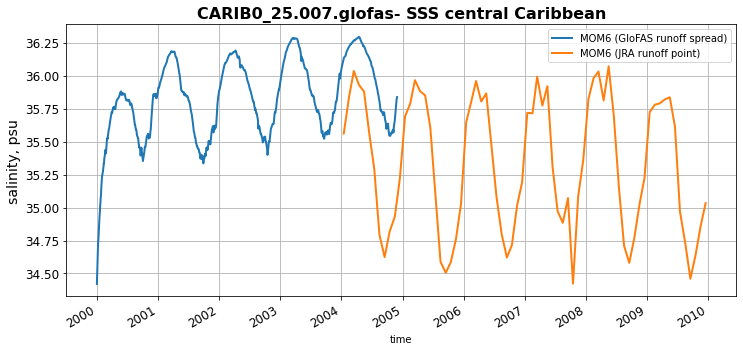

In [23]:
#plot salinity TS for subset region
dxr = ds_mom_subset['sos']
latstr='yh'
lonstr='xh'
if latstr == 'latitude':
    bfr = dxr.latitude
elif latstr == 'yh':
     bfr = dxr.yh       
weights = np.cos(np.deg2rad(bfr))
weights.name = "weights"
dxr_weighted = dxr.weighted(weights)
ds_mom_aw_subset = dxr_weighted.mean(("xh", "yh"))






#plot: 
figure = plt.figure(figsize=(12,5))
ds_mom_aw_subset.sel(time=slice('2000-01-01', '2005-12-31')).plot(linewidth=2)
argoS_aw['measurement'][:-5*12].plot(linewidth=2)
plt.title('CARIB0_25.007.glofas- SSS central Caribbean',fontweight="bold",fontsize=16)
plt.legend(['MOM6 (GloFAS runoff spread)','MOM6 (JRA runoff point)','RG Argo Gridded'])
plt.ylabel('salinity, psu',fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid()
plt.savefig(png_out + 'centralcarib_SSS_TS_mom_argo.png')

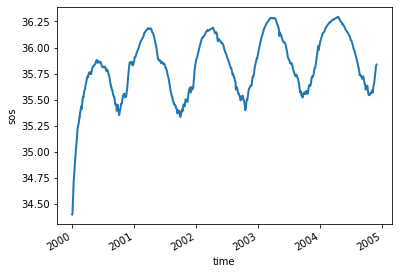

In [19]:
ds_mom_aw_subset.plot(linewidth=2)


FileNotFoundError: [Errno 2] No such file or directory: '/glade/work/gseijo/CARIB_025.007.glofas_proc/sfc_time_series/centralcarib_monthlymean_SSS_TS_mom_argo.png'

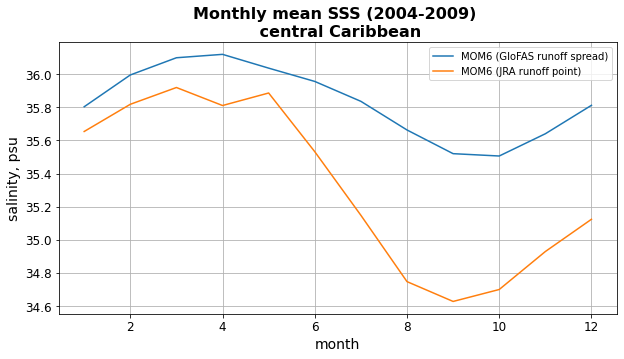

In [20]:
#calc monthly mean
figure = plt.figure(figsize=(10,5))
ds_mom_aw_subset.groupby("time.month").mean().plot()
argoS_aw['measurement'].groupby("time.month").mean().plot()
plt.title('Monthly mean SSS (2004-2009) \n central Caribbean',fontweight="bold",fontsize=16)
plt.legend(['MOM6 (GloFAS runoff spread)','MOM6 (JRA runoff point)','RG Argo Gridded'])
plt.ylabel('salinity, psu',fontsize=14)
plt.xlabel('month',fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid()
plt.savefig(png_out+'centralcarib_monthlymean_SSS_TS_mom_argo.png')

In [24]:
#monthly anomalies
ds_mom_aw_subset_monthly = ds_mom_aw_subset.resample(time='MS').mean()
mom6_month_anom = ds_mom_aw_subset_monthly.groupby("time.month") - ds_mom_aw_subset_monthly.groupby("time.month").mean()
argo_month_anom = argoS_aw['measurement'].groupby("time.month") - argoS_aw['measurement'].groupby("time.month").mean()


ValueError: x and y must have same first dimension, but have shapes (131,) and (72, 1)

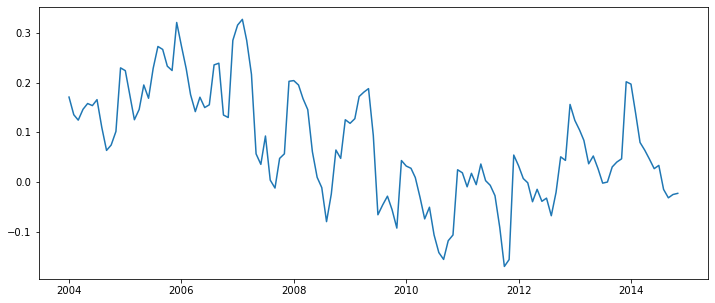

In [26]:
figure = plt.figure(figsize=(12,5))
plt.plot(ds_mom_aw_subset_monthly['time'][4*12+1:],mom6_month_anom[4*12+1:])
plt.plot(ds_mom_aw_subset_monthly['time'][4*12+1:],argo_month_anom[:-5*12])
#plt.xlim('2004-01-01T00:00','2009-12-31T00:00')
plt.title('Monthly SSS anomaly (2004-2009) \n central Caribbean',fontweight="bold",fontsize=16)
plt.legend(['MOM6 (GloFAS runoff spread)','MOM6 (JRA runoff point)','RG Argo Gridded'])
plt.ylabel('salinity anomaly, psu',fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid()
plt.savefig(png_out+'centralcaribbean_monthlyanomaly_SSS_TS_mom_argo.png')

In [30]:
mom6_month_anom_old

<xarray.DataArray 'sos' (time: 180)>
array([-0.60489509, -0.43205093, -0.30012161, -0.25756829, -0.30372596,
       -0.34511269, -0.21184478, -0.06687286,  0.05723135, -0.08508789,
       -0.30209902, -0.46110698, -0.32905854, -0.32072756, -0.2190644 ,
       -0.21931723, -0.10958317, -0.27545993, -0.17183139,  0.08182258,
       -0.01241763,  0.15805668, -0.14102173, -0.23963435, -0.30627778,
       -0.28593444, -0.24752418, -0.30263734, -0.22274723, -0.27474729,
        0.00830958, -0.04360739,  0.07740913,  0.24747635,  0.18949798,
        0.02279465, -0.01527728, -0.12552813, -0.09885789,  0.04213017,
        0.13170643,  0.16470645, -0.13144986,  0.20284256,  0.22046532,
        0.24028697,  0.33694133,  0.26421302,  0.17485077,  0.18150397,
        0.21024987,  0.26129083,  0.12017269,  0.05609074,  0.04564462,
        0.25433353,  0.04049456, -0.06474689, -0.02036174, -0.06721879,
       -0.12849968, -0.17191832, -0.17873238, -0.04259601, -0.0044258 ,
        0.05123633,  0.33646449,  0.39431469,  0.3445034 ,  0.13942761,
        0.10231652,  0.05942517,  0.10930082,  0.2581579 ,  0.16312188,
        0.10340485,  0.19100106,  0.28126515,  0.00799304, -0.21430337,
       -0.16345869, -0.00810833, -0.00743076,  0.30631798,  0.33158509,
        0.18211385,  0.18841676,  0.22953749,  0.08982771,  0.12599144,
        0.3256302 ,  0.21419977,  0.31158086,  0.21484735,  0.23355131,
        0.25296886,  0.21712694,  0.12276671,  0.2193926 ,  0.14339161,
        0.2751405 ,  0.02784892,  0.08212731, -0.01597412,  0.01447127,
        0.17422987,  0.1551209 ,  0.14946487,  0.21589189,  0.16736645,
        0.02875035,  0.0685418 ,  0.06078246,  0.1341854 , -0.18634688,
       -0.62576653, -0.52939864, -0.49861753, -0.17148632, -0.17293552,
       -0.04704383, -0.01338573, -0.06651632, -0.11027311, -0.09005681,
        0.15715048, -0.05013875,  0.07046798,  0.11498273,  0.04852013,
        0.09211075, -0.01112611,  0.02155878,  0.00334139, -0.00483796,
       -0.02210119,  0.00623049, -0.08285774,  0.14461619, -0.01148861,
       -0.36096409, -0.31599106, -0.10840082, -0.10444015,  0.11139452,
        0.20860242,  0.14353975, -0.01268967, -0.11039265, -0.14530437,
       -0.2432189 , -0.24057158, -0.01951122, -0.12120165, -0.03358249,
        0.15732104,  0.2224087 ,  0.20481885,  0.17823129,  0.03050257,
        0.04970729,  0.00380478,  0.25081391,  0.04871937,  0.0761124 ,
       -0.1477033 , -0.18301245, -0.20818594,  0.02693468,  0.02087356,
       -0.01604775,  0.08838352, -0.083637  ,  0.12120232, -0.20676878,
       -0.04811601, -0.17150075,  0.0186117 , -0.14214347,  0.05214228])
Coordinates:
  * time     (time) datetime64[ns] 1999-12-01 2000-01-01 ... 2014-11-01
    month    (time) int64 12 1 2 3 4 5 6 7 8 9 10 11 ... 1 2 3 4 5 6 7 8 9 10 11

## temp plots

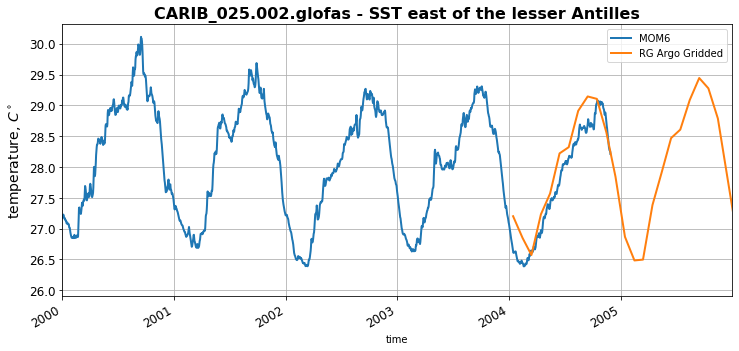

In [28]:
#plot salinity TS for subset region
dxr = ds_mom_subset['tos']
latstr='yh'
lonstr='xh'
if latstr == 'latitude':
    bfr = dxr.latitude
elif latstr == 'yh':
     bfr = dxr.yh       
weights = np.cos(np.deg2rad(bfr))
weights.name = "weights"
dxr_weighted = dxr.weighted(weights)
ds_mom_aw_subset = dxr_weighted.mean(("xh", "yh"))
#plot: 
figure = plt.figure(figsize=(12,5))
ds_mom_aw_subset.plot(linewidth=2)
argoT_aw['measurement'].plot(xlim=('2000-01-01T00:00','2005-12-31T00:00'),linewidth=2)
plt.title('CARIB_025.002.glofas - SST east of the lesser Antilles',fontweight="bold",fontsize=16)
plt.legend(['MOM6','RG Argo Gridded'])
plt.ylabel('temperature, $C^\circ$',fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid()
plt.savefig(png_out + 'eastantilles_SST_TS_mom_argo.png')

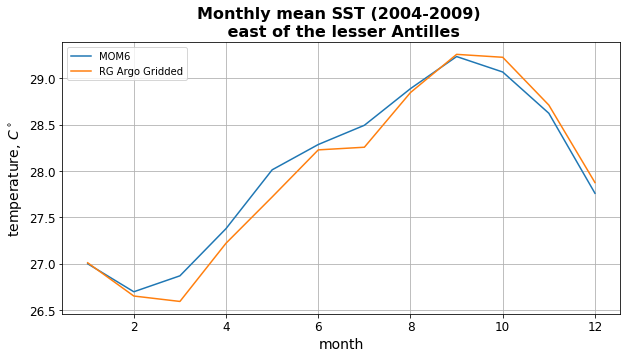

In [27]:
#calc monthly mean
figure = plt.figure(figsize=(10,5))
ds_mom_aw_subset.groupby("time.month").mean().plot()
argoT_aw['measurement'].groupby("time.month").mean().plot()
plt.title('Monthly mean SST (2004-2009) \n east of the lesser Antilles',fontweight="bold",fontsize=16)
plt.legend(['MOM6','RG Argo Gridded'])
plt.ylabel('temperature, $C^\circ$',fontsize=14)
plt.xlabel('month',fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid()
plt.savefig(png_out+'eastantilles_monthlymean_SST_TS_mom_argo.png')

ValueError: x and y must have same first dimension, but have shapes (131,) and (72, 1)

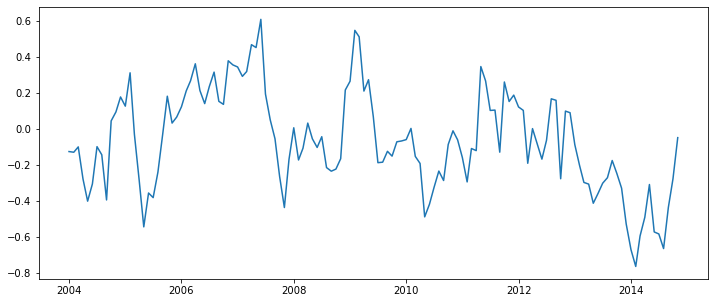

In [29]:
#monthly anomalies
ds_mom_aw_subset_monthly = ds_mom_aw_subset.resample(time='MS').mean()
mom6_month_anom = ds_mom_aw_subset_monthly.groupby("time.month") - ds_mom_aw_subset_monthly.groupby("time.month").mean()
argo_month_anom = argoT_aw['measurement'].groupby("time.month") - argoT_aw['measurement'].groupby("time.month").mean()
figure = plt.figure(figsize=(12,5))
plt.plot(ds_mom_aw_subset_monthly['time'][4*12+1:],mom6_month_anom[4*12+1:])
plt.plot(ds_mom_aw_subset_monthly['time'][4*12+1:],argo_month_anom[:-5*12])
plt.xlim('2004-01-01T00:00','2009-12-31T00:00')
plt.title('Monthly SST anomaly (2004-2009) \n east of the lesser Antilles',fontweight="bold",fontsize=16)
plt.legend(['MOM6','RG Argo Gridded'])
plt.ylabel('temperature anomaly, $C^\circ$',fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid()
plt.savefig(png_out+'eastantilles_monthlyanomaly_SST_TS_mom_argo.png')